 # modéle 1

### Notre code met en place un système de recommandation de films basé sur le contenu en utilisant : ✔ TF-IDF pour transformer le texte en vecteurs numériques ✔ KNN (K-Nearest Neighbors) pour trouver les films les plus similaires

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import ast
import warnings  

In [24]:

nltk.download('punkt')         # pour le tokeniseur de phrases/mots
nltk.download('stopwords')     # pour les mots vides comme "le", "la", "et", etc.
nltk.download('wordnet')       # pour la lemmatisation
nltk.download('omw-1.4')       # ressources linguistiques supplémentaires


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
warnings.filterwarnings("ignore")

In [26]:
#  Charger les données
df = pd.read_csv('movie_data_cleaned.csv')  # Remplace par ton fichier CSV

In [27]:
 # Fonction pour convertir les colonnes JSON (cast, genres, keywords)
def extract_names(text):
    try:
        return ' '.join([i['name'] for i in ast.literal_eval(text)])
    except:
        return ''

In [28]:
 # Nettoyage et création d'une colonne "tags"
df['overview'] = df['overview'].fillna('')
df['cast'] = df['cast'].apply(extract_names)
df['genres'] = df['genres'].apply(extract_names)
df['keywords'] = df['keywords'].apply(extract_names)

In [29]:
df['tags'] = df['overview'] + ' ' + df['genres'] + ' ' + df['cast'] + ' ' + df['keywords']
df['tags'] = df['tags'].str.lower()

In [30]:
#  Vectorisation avec TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['tags'])

In [31]:
#. Modèle KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Objectif → Créer un modèle KNN qui trouve les films similaires en utilisant la distance cosinus. 🔹 Pourquoi ? → La distance cosinus permet de comparer l’orientation des textes plutôt que leur simple contenu.

In [32]:
import joblib

# 💾 Sauvegarder le modèle KNN
joblib.dump(model_knn, "knn_model.pkl")
print("✅ Modèle KNN sauvegardé avec succès sous 'knn_model.pkl' !")


✅ Modèle KNN sauvegardé avec succès sous 'knn_model.pkl' !


In [33]:
import pandas as pd
import numpy as np
import joblib
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# 📂 1️⃣ Charger les données des films
df = pd.read_csv("movie_data_cleaned.csv")

# 🔄 2️⃣ Vérifier et créer la colonne "tags" si elle n'existe pas
if "tags" not in df.columns:
    df["tags"] = df["overview"].fillna('') + ' ' + df["genres"].fillna('') + ' ' + df["cast"].fillna('') + ' ' + df["keywords"].fillna('')
    df["tags"] = df["tags"].str.lower()
    print("✅ Colonne 'tags' recréée avec succès !")

# 📊 3️⃣ Vectorisation TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["tags"])

# 🔄 4️⃣ Charger le modèle KNN sauvegardé
model_knn = joblib.load("knn_model.pkl")
print("✅ Modèle KNN chargé avec succès !")

# 🎯 5️⃣ Fonction de recommandation avec KNN
def recommend_knn(title, k=5):
    """Retourne les k films les plus similaires en utilisant le modèle KNN sauvegardé."""

    title = title.lower()
    matches = df[df["title"].str.contains(title, case=False)]
    
    if matches.empty:
        return ["❌ Film non trouvé. Essayez un autre titre."]
    
    idx = matches.index[0]
    tfidf_vector = tfidf_matrix[idx]

    # 🔥 Utilisation du modèle KNN pour trouver les films similaires
    distances, indices = model_knn.kneighbors(tfidf_vector, n_neighbors=k+1)

    print(f"\n🎬 Films similaires à '{df.iloc[idx].title}' :\n")

    for i in range(1, len(distances[0])):
        similarity_percentage = round((1 - distances[0][i]) * 100, 2)  # Conversion en pourcentage
        print(f"{df.iloc[indices[0][i]].title} - {similarity_percentage}% de similarité")

# 🎬 6️⃣ Tester la recommandation avec le modèle KNN sauvegardé
user_movie = input("🎬 Entrez un titre de film : ")
recommend_knn(user_movie)


✅ Colonne 'tags' recréée avec succès !
✅ Modèle KNN chargé avec succès !

🎬 Films similaires à 'Toy Story' :

Tarantulas: The Deadly Cargo - 20.41% de similarité
Sympathy for Mr. Vengeance - 19.9% de similarité
The Flight of the Phoenix - 15.99% de similarité
The Flyboys - 15.9% de similarité
Sleuth - 15.8% de similarité


# modele 2

In [3]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import os

# 1️⃣ Vérifier et charger le dataset
file_path = "movie_data_cleaned.csv"
if not os.path.exists(file_path):
    print(f"❌ Erreur : Le fichier '{file_path}' n'existe pas !")
    exit()

df = pd.read_csv(file_path)
df.fillna("", inplace=True)


In [4]:
# 2️⃣ Vérifier les colonnes nécessaires
columns_needed = ["title", "genres", "overview", "popularity", "vote_average", "runtime", "keywords", "cast"]
missing_columns = [col for col in columns_needed if col not in df.columns]
if missing_columns:
    print(f"❌ Erreur : Colonnes manquantes dans le dataset: {missing_columns}")
    exit()

df = df[columns_needed]

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df["genres_list"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
df_genres = pd.DataFrame(mlb.fit_transform(df["genres_list"]), columns=mlb.classes_)
df = pd.concat([df, df_genres], axis=1)  # Fusionner les genres binaires avec le dataset


In [6]:
 #3️⃣ Transformer les genres en variables binaires
mlb = MultiLabelBinarizer()
df["genres_list"] = df["genres"].apply(lambda x: x.split(",") if isinstance(x, str) else [])
df_genres = pd.DataFrame(mlb.fit_transform(df["genres_list"]), columns=mlb.classes_)
df = pd.concat([df, df_genres], axis=1)

In [7]:
# 4️⃣ Transformer le texte en embeddings avec gestion des erreurs
model = SentenceTransformer('all-MiniLM-L6-v2')
df["text_embedding"] = df.apply(lambda row: model.encode(row["overview"] + " " + row["keywords"] + " " + row["cast"]) if row["overview"] else np.zeros(384), axis=1)



In [8]:
# 5️⃣ Standardiser les colonnes numériques
scaler = StandardScaler()
df[["popularity", "vote_average", "runtime"]] = scaler.fit_transform(df[["popularity", "vote_average", "runtime"]])


In [9]:
print("Colonnes des genres binaires :")
print(df_genres.head())  # Vérifier les premières lignes de df_genres
print("Présence des genres dans df :")
print(df.head())  # Vérifier que les colonnes ont bien été fusionnées


Colonnes des genres binaires :
    Action   Adventure   Animation   Comedy   Crime   Documentary   Drama  \
0        0           0           0        1       0             0       0   
1        0           0           0        0       0             0       0   
2        0           0           0        1       0             0       0   
3        0           0           0        0       0             0       1   
4        0           0           0        0       0             0       0   

    Family   Fantasy   Foreign  ...  History  Horror  Music  Mystery  Romance  \
0        1         0         0  ...        0       0      0        0        0   
1        1         1         0  ...        0       0      0        0        0   
2        0         0         0  ...        0       0      0        0        1   
3        0         0         0  ...        0       0      0        0        0   
4        0         0         0  ...        0       0      0        0        0   

   Science Fiction 

In [10]:
# 6️⃣ Fusionner les embeddings, genres et données numériques
X = np.concatenate((
    np.array(df["text_embedding"].tolist()),  # Embeddings textuels
    np.array(df[["popularity", "vote_average", "runtime"]].values),  # Données numériques standardisées
    np.array(df[df_genres.columns].values)  # Genres binaires
), axis=1)

In [12]:
print(f"✅ Dimensions de X : {X.shape}")

✅ Dimensions de X : (29706, 467)


In [11]:
# 7️⃣ Appliquer K-Means Clustering (100 groupes)
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

In [13]:
cluster_num = 5
movies_in_cluster = df[df["cluster"] == cluster_num]["title"].tolist()
print(f"🎬 Films du cluster {cluster_num}: {movies_in_cluster[:10]}")  # Affiche les 10 premiers


🎬 Films du cluster 5: ['Dream Man', 'The Old Lady Who Walked in the Sea', 'After Image', 'Sweepers', 'Come On, Rangers', 'Live Music', 'Nazty Nuisance', 'My Avatar and Me', 'Find Love', 'Bells of Capistrano']


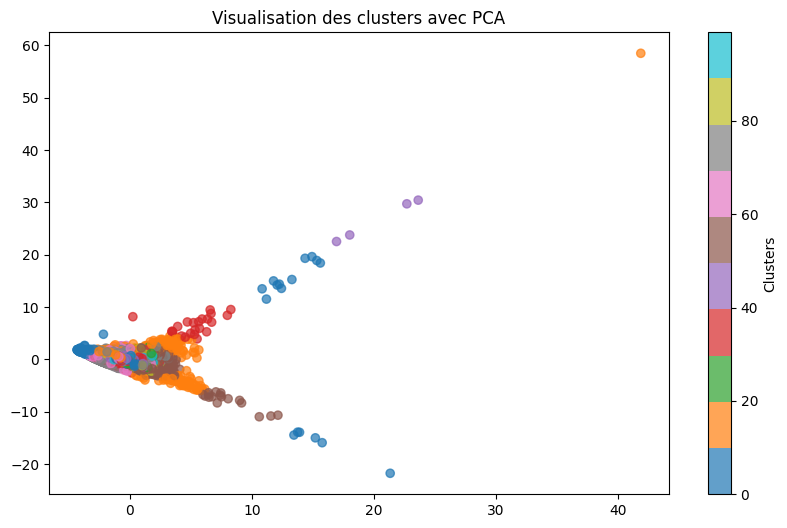

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap="tab10", alpha=0.7)
plt.colorbar(label="Clusters")
plt.title("Visualisation des clusters avec PCA")
plt.show()


In [15]:
def get_movie_recommendations(df):
    user_movie = input("🎬 Entrez le titre du film que vous aimez : ")
    
    if user_movie not in df["title"].values:
        print("❌ Désolé, ce film n'est pas dans la base de données.")
        return
    
    user_cluster = df[df["title"] == user_movie]["cluster"].values[0]
    cluster_df = df[df["cluster"] == user_cluster].copy()

    user_embedding = df[df["title"] == user_movie]["text_embedding"].values[0]
    
    if isinstance(user_embedding, float):  
        print(f"❌ Pas d'embedding disponible pour '{user_movie}'.")
        return
    
    similarities = cosine_similarity([user_embedding], np.array(cluster_df["text_embedding"].tolist()))[0]
    
    cluster_df["similarity_score"] = similarities
    cluster_df["popularity_norm"] = cluster_df["popularity"] / cluster_df["popularity"].max()
    cluster_df["vote_norm"] = cluster_df["vote_average"] / cluster_df["vote_average"].max()
    cluster_df["runtime_norm"] = cluster_df["runtime"] / cluster_df["runtime"].max()

    cluster_df["score"] = (
        0.50 * cluster_df["similarity_score"] +
        0.20 * cluster_df["popularity_norm"] +
        0.20 * cluster_df["vote_norm"] +
        0.10 * cluster_df["runtime_norm"]
    )

    sorted_movies = cluster_df.sort_values("score", ascending=False)[["title", "score"]]
    top_movies = sorted_movies[sorted_movies["title"] != user_movie].head(5)

    print(f"\n🎬 Films recommandés pour '{user_movie}':")
    for _, row in top_movies.iterrows():
        print(f"👉 {row['title']} (Score: {row['score']:.2f})")

# Exécuter la fonction
get_movie_recommendations(df)




🎬 Films recommandés pour 'Toy Story':
👉 Toy Story 3 (Score: 0.64)
👉 Toy Story 2 (Score: 0.62)
👉 Monsters, Inc. (Score: 0.47)
👉 Zootopia (Score: 0.44)
👉 E.T. the Extra-Terrestrial (Score: 0.44)


In [16]:
import joblib

# 📂 Sauvegarde du modèle K-Means
joblib.dump(kmeans, "kmeans_model.pkl")
print("✅ Modèle K-Means sauvegardé avec succès ! 📂")


✅ Modèle K-Means sauvegardé avec succès ! 📂


In [17]:
df.to_csv("movie_data.csv", index=False)
print("✅ Fichier 'movie_data.csv' sauvegardé avec succès !")


✅ Fichier 'movie_data.csv' sauvegardé avec succès !


### fonction de modele pour intégration 

In [18]:
# ────────────────────────────────────────────────────────────────
#  MOVIE RECOMMENDER — case-insensitive & fuzzy title lookup
# ────────────────────────────────────────────────────────────────
import ast, json, joblib, numpy as np, pandas as pd, difflib
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# ---------- tolerant embedding parser ----------
def clean_embedding(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=np.float32)
    s = str(x).strip()
    if s.lower() in {"none", "null", "nan", ""}:
        return None
    for parser in (
        lambda y: ast.literal_eval(y),                       # "[0.1,0.2]"
        lambda y: json.loads(y.replace(" ", ",")),           # "[0.1 0.2]"
        lambda y: [float(tok) for tok in y.strip("[]").replace(",", " ").split()]
    ):
        try:
            return np.asarray(parser(s), dtype=np.float32)
        except Exception:
            continue
    return None

# ---------- load model + data ----------
print("📂 Loading model & data …")
kmeans = joblib.load("kmeans_model.pkl")           # only needed if you recluster later
df = pd.read_csv("movie_data.csv")

needed = ["title", "text_embedding", "popularity", "vote_average", "runtime", "cluster"]
if missing := set(needed) - set(df.columns):
    raise ValueError(f"CSV missing columns: {missing}")

df["text_embedding"] = df["text_embedding"].apply(clean_embedding)
df = df[df["text_embedding"].notna()].reset_index(drop=True)
if df.empty:
    raise RuntimeError("⚠️  After cleaning, zero rows remain. Check embedding format.")

print(f"✅ Ready → {len(df)} movies across {df['cluster'].nunique()} clusters")

# ---------- fast case-insensitive lookup dict ----------
lower2title = {t.lower(): t for t in df["title"].unique()}

def resolve_title(user_input: str) -> str | None:
    """
    Return the canonical movie title matching `user_input`
    (case-insensitive). If no direct match, try fuzzy suggestions.
    """
    key = user_input.strip().lower()
    if key in lower2title:
        return lower2title[key]

    # fuzzy suggestions (edit distance / similarity)
    possibilities = difflib.get_close_matches(key, lower2title.keys(), n=3, cutoff=0.6)
    if possibilities:
        suggestion = lower2title[possibilities[0]]
        yn = input(f"❓ Did you mean '{suggestion}'? [Y/n] ").strip().lower()
        if yn in {"", "y", "yes"}:
            return suggestion
    return None

# ---------- recommender ----------
def recommend(title, df, k=5):
    row = df.loc[df["title"] == title].iloc[0]
    emb, cl = row["text_embedding"], row["cluster"]
    sub = df[df["cluster"] == cl].copy()

    sims = cosine_similarity(emb.reshape(1, -1),
                             np.vstack(sub["text_embedding"].values)).ravel()
    sub["similarity_score"] = sims

    for col, new in [("popularity", "popularity_norm"),
                     ("vote_average", "vote_norm"),
                     ("runtime", "runtime_norm")]:
        m = sub[col].max(skipna=True)
        sub[new] = sub[col] / m if m else 0

    sub["score"] = (0.50 * sub["similarity_score"] +
                    0.20 * sub["popularity_norm"] +
                    0.20 * sub["vote_norm"] +
                    0.10 * sub["runtime_norm"])

    return (sub[sub["title"] != title]
            .sort_values("score", ascending=False)
            .loc[:, ["title", "score"]]
            .head(k)
            .reset_index(drop=True))



📂 Loading model & data …
✅ Ready → 29706 movies across 100 clusters


In [19]:
# ---------- interactive ----------
raw = input("🎬 Enter a movie you like: ")
canonical = resolve_title(raw)

if canonical:
    print(f"\n💡 Using title: {canonical}")
    recs = recommend(canonical, df)
    print(f"\n🎬 Recommendations for '{canonical}':")
    display(recs)
else:
    print("❌ No matching title found.")


💡 Using title: Avatar

🎬 Recommendations for 'Avatar':


,title,score
0,Pulp Fiction,0.600617
1,Guardians of the Galaxy Vol. 2,0.588244
2,Captain America: Civil War,0.515617
3,Gone Girl,0.511807
4,The Dark Knight,0.487098


# modéle 3

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 📂 Charger le dataset des films
df = pd.read_csv("movie_data_cleaned.csv")

# 🔄 Sélection des colonnes pertinentes
features = ["popularity", "vote_average", "runtime", "genres"]
df = df[["title"] + features]

# 🔄 Encodage des genres en valeurs numériques
label_encoder = LabelEncoder()
df["genres_encoded"] = label_encoder.fit_transform(df["genres"])

# 💾 Sauvegarde des données préparées
df.to_csv("movie_data_prepared.csv", index=False)
print("✅ Données prêtes pour l'entraînement !")


✅ Données prêtes pour l'entraînement !


In [21]:
import lightgbm as lgb
import joblib

# 📂 Charger les données préparées
df = pd.read_csv("movie_data_prepared.csv")

X = df[["popularity", "vote_average", "runtime", "genres_encoded"]]
y = np.random.rand(len(X))  # Simuler une cible (à remplacer par des vraies données)

# 🔄 Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Entraîner LightGBM
model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, num_leaves=50)
model.fit(X_train, y_train)

# 💾 Sauvegarder le modèle
joblib.dump(model, "lightgbm_model.pkl")
print("✅ Modèle LightGBM entraîné et sauvegardé avec succès !")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 23764, number of used features: 4
[LightGBM] [Info] Start training from score 0,499891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [22]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# 📂 Charger le modèle et les données
movies_df = pd.read_csv("movie_data_prepared.csv")
model = joblib.load("lightgbm_model.pkl")

def recommend_movies(movie_title, k=5):
    """Retourne k films similaires au film donné par l'utilisateur"""
    
    if movie_title not in movies_df["title"].values:
        return "❌ Film non trouvé."

    # 🔍 Récupérer les caractéristiques du film
    movie_features = movies_df[movies_df["title"] == movie_title][["popularity", "vote_average", "runtime", "genres_encoded"]]

    # 🔥 Trouver les films similaires avec LightGBM
    movies_df["score"] = model.predict(movies_df[["popularity", "vote_average", "runtime", "genres_encoded"]])

    # 🎬 Sélection des meilleurs films
    recommendations = movies_df.sort_values("score", ascending=False).head(k)[["title", "score"]]
    
    return recommendations

# 🎬 Exemple d'utilisation
user_movie = input("🎬 Entrez un titre de film : ")
print(recommend_movies(user_movie))


                             title     score
14185         Count Three and Pray  0.771579
8732   Dilwale Dulhania Le Jayenge  0.753126
20827            The Hateful Eight  0.752935
28524                  Prohibition  0.739519
11099                        Gypsy  0.739088


# modéle 4 

### ✔ Travaille avec la recommandation basée sur le contenu → Pas besoin de données utilisateur. ✔ Utilise TF-IDF pour transformer les descriptions des films en vecteurs → Meilleure compréhension des thématiques. ✔ Entraînement d’un réseau de neurones (MLP) → Apprend à prédire les films les plus similaires. ✔ Combine Similarité Cosinus + Deep Learning → Optimise la précision des recommandations.

In [40]:
pip install tensorflow


  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-cp311-cp311-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached 

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
